<a href="https://colab.research.google.com/github/giuliocapecchi/LM-project/blob/main/lm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import torch
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import CharacterTextSplitter
import re
from unidecode import unidecode
import transformers
import random

# ------------------------------------------------------------------------- #
# Preprocess text to remove formulas and strange characters
def preprocess_text(text):
    # Rimuovi formule matematiche LaTeX
    text = re.sub(r'\$.*?\$', '', text)
    # Rimuovi caratteri non alfanumerici eccetto punteggiatura di base
    text = re.sub(r'[^a-zA-Z0-9\s.,;:!?\'"-]', '', text)
    # Rimuovi •
    text = text.replace('•', '')
    # Normalizza i caratteri Unicode
    text = unidecode(text)
    # Rimuovi spazi multipli
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def aggregate_short_documents(texts, min_length=50):
    aggregated_texts = []
    buffer = ""
    
    for doc in texts:
        if len(doc.page_content) < min_length:
            buffer += " " + doc.page_content
        else:
            if buffer:
                doc.page_content = buffer + " " + doc.page_content
                buffer = ""
            aggregated_texts.append(doc)
    
    if buffer:
        if aggregated_texts:
            aggregated_texts[-1].page_content += " " + buffer
        else:
            aggregated_texts.append(buffer)
    
    return aggregated_texts

# ------------------------------------------------------------------------- #

# Load and process the PDF
loader = PyMuPDFLoader("IR Slides v1.0.pdf")
documents = loader.load()

# Split the documents into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200, separator="\n")
texts = text_splitter.split_documents(documents)

# Preprocess the text
for doc in texts:
    doc.page_content = preprocess_text(doc.page_content)

# Aggrega i documenti corti
corpus = aggregate_short_documents(texts)

In [36]:
print(f"Average document length: {sum(len(doc.page_content) for doc in corpus) / len(corpus)}")

Average document length: 464.4107744107744


In [37]:
import os

def save_documents(documents):
    if not os.path.exists("vector_store"):
        os.makedirs("vector_store")
    # delete all files in the vector_store directory
    for file in os.listdir("vector_store"):
        os.remove(os.path.join("vector_store", file))
    for i, doc in enumerate(documents):
        with open(f"vector_store/document_{i}.txt", "w", encoding="utf-8") as f:
            f.write(doc.page_content)

save_documents(corpus)

In [38]:
print(f"Saved {len(corpus)} documents in the vector_store directory.")

Saved 297 documents in the vector_store directory.


In [39]:
import json

def extract_questions(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    questions = []
    for item in data:
        # q = item.get("question", "")
        # a = item.get("answers", "")
        # # 'a' è una lista di stringhe, aggiungi ad ognuno 1, 2, 3, 4
        # for i in range(len(a)):
        #     a[i] = f"{(1 + i)}) {a[i]}"
        # a = " ".join(a)
        # qplusa = f"{q} {a}"
        if str(item.get("category", "")) == "1":
            continue
        question = {
            "question": item.get("question", ""),
            # "answers": item.get("answers", ""),
            # "correct": item.get("correct", ""),
            # "category": item.get("category", ""),
            # "question_id": item.get("question_id", "")
        }
        questions.append(question)
    return questions


queries = extract_questions('quiz/quiz.json')
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Loaded 60 questions.
{'question': 'Which of the following metrics is used to measure overlap between two sets?'}


# 1. Gather dataset embeddings
- CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.
- Now that we have obtained "dataset embeddings" we can embed documents and queries like normal. Remember to use the document prompt for documents:

In [40]:
from sentence_transformers import SentenceTransformer

# prefixes for queries and documents (we need them for cde-small-v1)
query_prefix = "search_query: "
document_prefix = "search_document: "

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Load the model
model = SentenceTransformer("jxm/cde-small-v1", trust_remote_code=True).to(device)
from sentence_transformers import SimilarityFunction

Using device: cuda


C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\eb02ceb48c1fdcc477ff1925c9732c379f0f0d1f\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


In [41]:
minicorpus_size = model[0].config.transductive_corpus_size # 512
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversample
assert len(minicorpus_docs) == minicorpus_size # You must use exactly this many documents in the minicorpus. You can oversample if your corpus is smaller.

dataset_embeddings = model.encode(
    [document_prefix + doc.page_content for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True
)

In [42]:
print(f"Corpus size: {len(corpus)}")
print(f"Minicorpus size: {len(minicorpus_docs)}")
print(f"Embeddings shape: {dataset_embeddings.shape}")

print("Some mini-corpus documents:")
for i, doc in enumerate(minicorpus_docs[:5]):
    print(f"Document {i+1}: {doc.page_content[:100]}...")

Corpus size: 297
Minicorpus size: 512
Embeddings shape: torch.Size([512, 768])
Some mini-corpus documents:
Document 1: Offline Evaluation Pros The experimental condition is fixed; same queries, and same relevance judgem...
Document 2: advertising, 218, 371 classifying, 371 contextual, 218221 agglomerative clustering, 375 anchor text,...
Document 3: 2-Poisson Model Using eliteness, we have We assume two different distributions, one for elite and on...
Document 4: Suppose Herbie goes for a time , say 10 minutes, at speed , say 60 kmh, and for the same amount of t...
Document 5: Weighting TF and IDF together Term frequency weight: Inverse document frequency weight: TFIDF term w...


# 2. Get doc embeddings

In [43]:
from tqdm.notebook import tqdm

# Define batch size
batch_size = 1

# Function to encode in batches
def encode_in_batches(texts, batch_size, prompt_name):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc=f"Encoding {prompt_name}"):
        batch_texts = texts[i:i + batch_size]
        prefix = document_prefix if prompt_name == "document" else query_prefix
        batch_embeddings = model.encode(
            [prefix + text for text in batch_texts],
            prompt_name=prompt_name,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
        )
        embeddings.append(batch_embeddings)
    return torch.cat(embeddings)

# Prepare document texts and query texts
doc_texts = [document_prefix + doc.page_content for doc in corpus]
query_texts = [query_prefix + query['question'] for query in queries]

# Encode document texts and query texts in batches
doc_embeddings = encode_in_batches(doc_texts, batch_size, "document")
query_embeddings = encode_in_batches(query_texts, batch_size, "query")

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {query_embeddings.shape}")

Encoding document:   0%|          | 0/297 [00:00<?, ?it/s]

Encoding query:   0%|          | 0/60 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([297, 768])
Query embeddings shape: torch.Size([60, 768])


In [ ]:
similarities = model.similarity(query_embeddings, doc_embeddings)
topk_values, topk_indices = similarities.topk(5)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx]
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc.page_content[:200]}...")
    print()


Query: Which of the following metrics is used to measure overlap between two sets?
Rank 1 (Score: 0.5720, Doc ID: 73): Jaccard Coefficient A common measure of overlap of two finite sets and : Always assigns a number between 0 and 1 and do not have to be the same size Note that and if What is the query-document match s
Rank 2 (Score: 0.5499, Doc ID: 288): AB Testing Concept is fairly trivial: randomly split traffic between two or more versions A Control B Treatment Collect metrics of interest analyse Run statistical tests to confirm differences are not
Rank 3 (Score: 0.5436, Doc ID: 135): The -test assumes that the evaluation data is measure on an interval scale Differences between values are significant Effectiveness measures are an ordinal scale Differences between values are not sig
Rank 4 (Score: 0.5245, Doc ID: 113): Precision and recall are two different numbers to evaluate the effectiveness of an IR system Can we coalesce them in a single performance number? F-measure is a mean b

# 3. Chroma

In [45]:
from chromadb import Client, Collection

# Initialize the Chroma client
client = Client()

COLLECTION_NAME = "ir_slides"

# Check if the collection exists and delete it if it does
if COLLECTION_NAME in [col.name for col in client.list_collections()]:
    client.delete_collection(name=COLLECTION_NAME)
    print(f"Collection {COLLECTION_NAME} exists, deleting it")
else:
    print(f"Collection {COLLECTION_NAME} does not exist")

Collection ir_slides exists, deleting it


In [46]:
from chromadb import Documents, EmbeddingFunction, Embeddings

class CustomEmbeddingFunction(EmbeddingFunction):
    def __init__(self, mode="document"):
        self.mode = mode  # "document" or "query"
        
    def __call__(self, input: Documents) -> Embeddings:
        prompt_name = "document" if self.mode == "document" else "query"
        prefix = "search_document: " if self.mode == "document" else "search_query: "

        # se input è una lista di documenti, estrai il testo
        if isinstance(input, list):
            input = [prefix + doc if isinstance(doc, str) else prefix + doc.page_content for doc in input]

        # Genera embeddings usando il modello specifico
        embeddings = model.encode(
            input,
            prompt_name=prompt_name,
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True,
        ).cpu().numpy()
        
        return embeddings.tolist()

# Create an instance of your embedding function
doc_embedding_function = CustomEmbeddingFunction(mode="document")

# Create a Chroma collection with the custom embedding function
collection: Collection = client.create_collection(
    name=COLLECTION_NAME,
    embedding_function=doc_embedding_function,
    get_or_create=True,
    metadata={"hnsw:space": "cosine"} # l2 is the default but cosine is more suitable for this embedding function
)

# Add the documents to the collection
collection.add(
    ids=[str(i) for i in range(len(doc_texts))],  # Unique identifiers for the documents
    embeddings=doc_embeddings.cpu().numpy(),
    documents=doc_texts,
)

In [47]:
#print(collection.peek()) # returns a list of the first 10 items in the collection
print(collection.count()) # returns the number of items in the collection

297


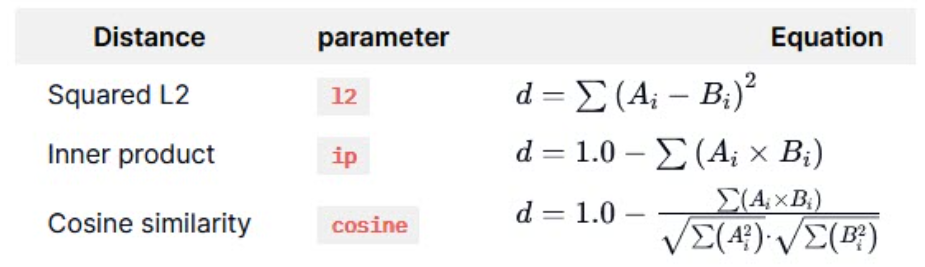

In [48]:
# Example query
query_text = "Which of the following metrics is used to measure overlap between two sets?"
query_embedding_function = CustomEmbeddingFunction(mode="query")
query_embeddings = query_embedding_function(query_text)

#print(query_embeddings)

results = collection.query(
    query_embeddings=query_embeddings,
    n_results=5
)

# Print the results with the document IDs and scores
for i, (doc_id, score) in enumerate(zip(results['ids'][0], results['distances'][0])):
    print(f"Rank {i+1}: Document ID: {doc_id}, Score: {1-score}, {corpus[int(doc_id)].page_content[:200]}")

Rank 1: Document ID: 135, Score: 0.5504749417304993, The -test assumes that the evaluation data is measure on an interval scale Differences between values are significant Effectiveness measures are an ordinal scale Differences between values are not sig
Rank 2: Document ID: 288, Score: 0.5502256155014038, AB Testing Concept is fairly trivial: randomly split traffic between two or more versions A Control B Treatment Collect metrics of interest analyse Run statistical tests to confirm differences are not
Rank 3: Document ID: 173, Score: 0.512598991394043, Since we use odds and logarithm it is more numerically robust to use a small smoothing factor: Estimating and pi ri relevant not-relevant total term present term not present total ri 0.5 ni ri 0.5 ni 
Rank 4: Document ID: 290, Score: 0.5044369697570801, Interleaving Procedure Generate interleaved result list Keep track of assignments which ranker contributed which document Observe user behaviour e.g., clicks Credit clicks to original ra

# 3. Compute scores between queries and documents

In [49]:
query_embeddings = model.encode(
    [query_prefix + query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,
    convert_to_tensor=True,
)

doc_embeddings = model.encode(
    [document_prefix + doc.page_content for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings,
    convert_to_tensor=True,
)

similarities = model.similarity(query_embeddings, doc_embeddings)
print(similarities.shape)

torch.Size([60, 297])


<Axes: >

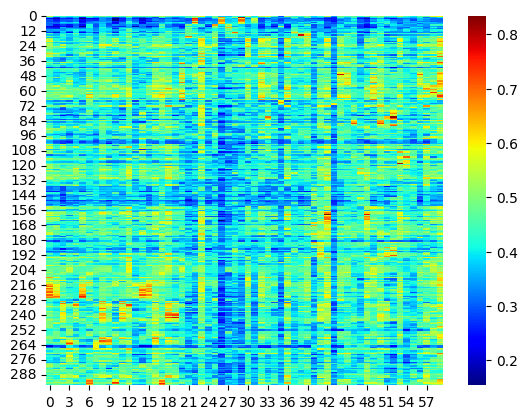

In [50]:
from seaborn import heatmap

heatmap(similarities.cpu().numpy().T, cmap="jet")

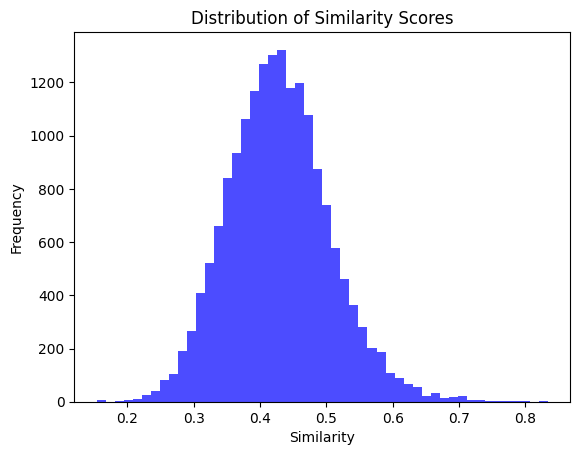

In [51]:
import matplotlib.pyplot as plt

plt.hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity")
plt.ylabel("Frequency")
plt.show()
